In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import shutil

In [ ]:
import zipfile
with zipfile.ZipFile('/content/data.zip','r') as zip_ref:
  zip_ref.extractall()

In [ ]:
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [ ]:
class Classifier:
    def __init__(self):
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

In [ ]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])

    def init_model(self):
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))

        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [ ]:
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [ ]:
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7105 images belonging to 3 classes.


In [ ]:
generator.class_indices

In [ ]:
shutil.rmtree('data/.ipynb_checkpoints', ignore_errors=True)

In [ ]:
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')
generator.class_indices

1/1 [==============================] - 0s 39ms/step
Predicted likelihood: 0.6642
Actual label: 1
1/1 [==============================] - 0s 38ms/step

Correct prediction: True


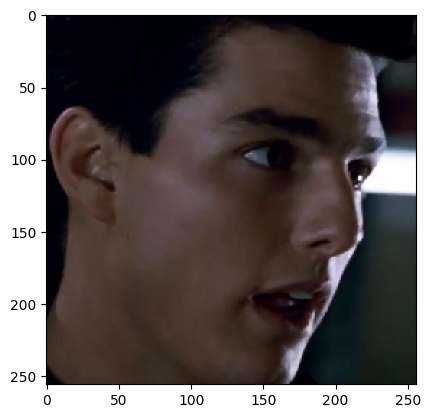

In [78]:
X, y = generator.next()

print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

plt.imshow(np.squeeze(X));

In [ ]:
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
for i in range(len(generator.labels)):
    X, y = generator.next()
    pred = meso.predict(X)[0][0]

    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)

    if i % 1000 == 0:
        print(i, ' predictions completed.')

    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

In [ ]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

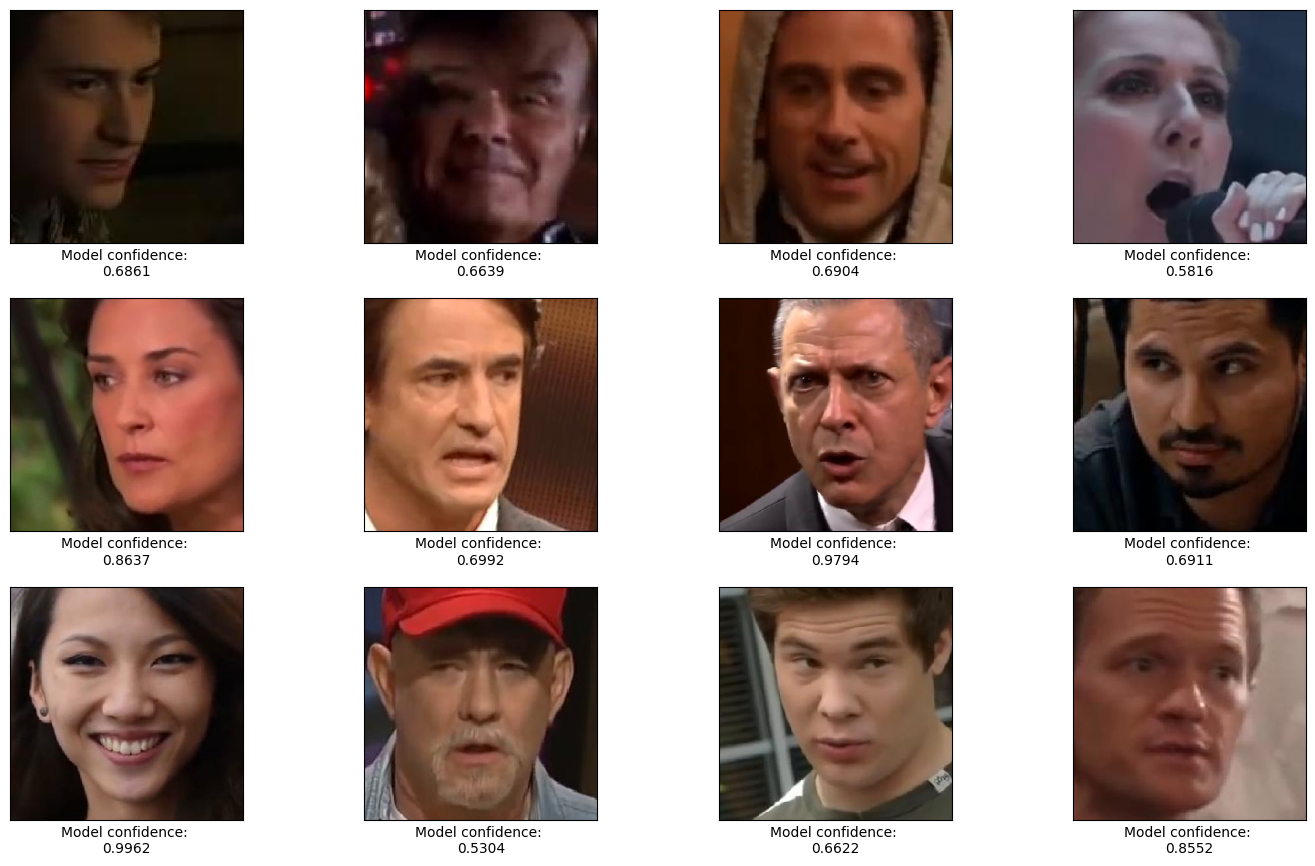

In [79]:
plotter(correct_real, correct_real_pred)

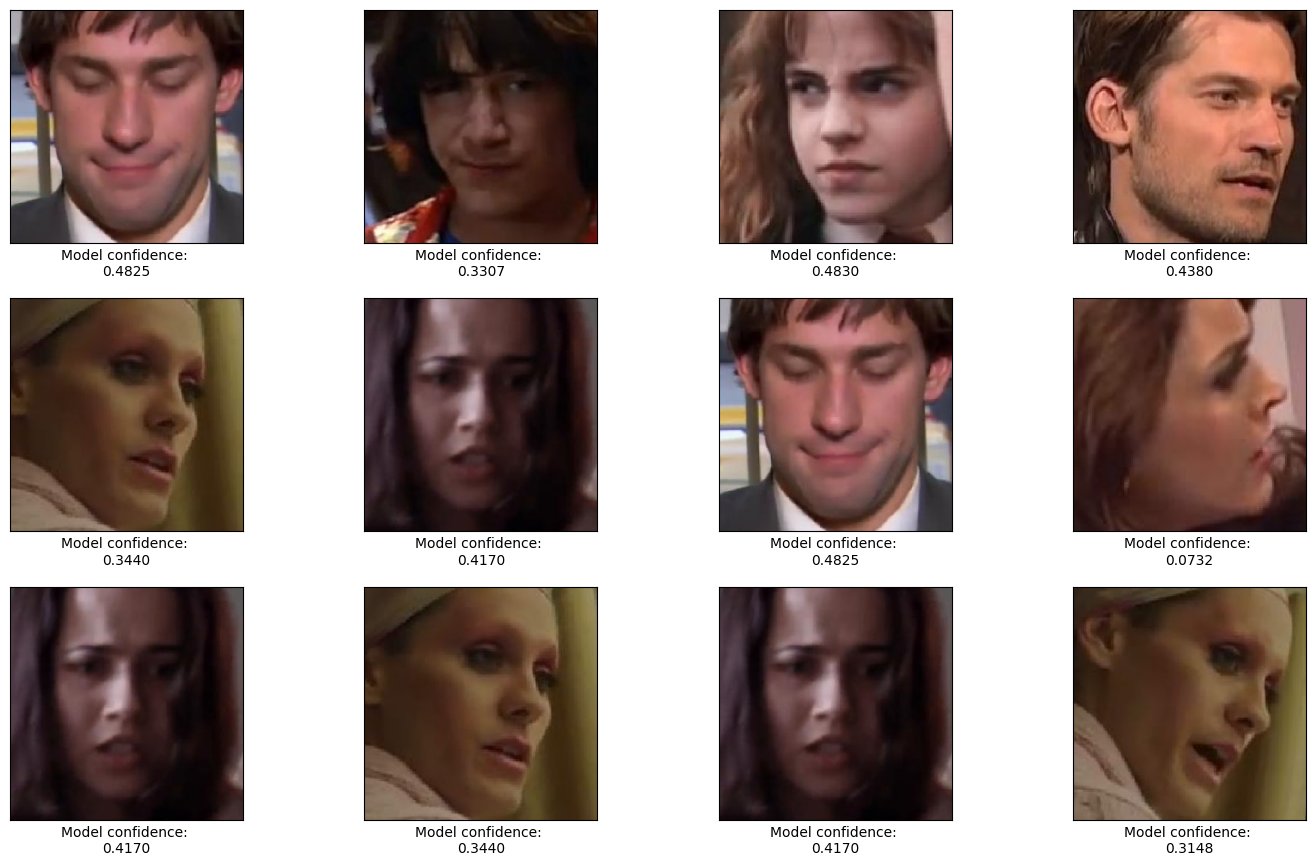

In [80]:
plotter(misclassified_real, misclassified_real_pred)

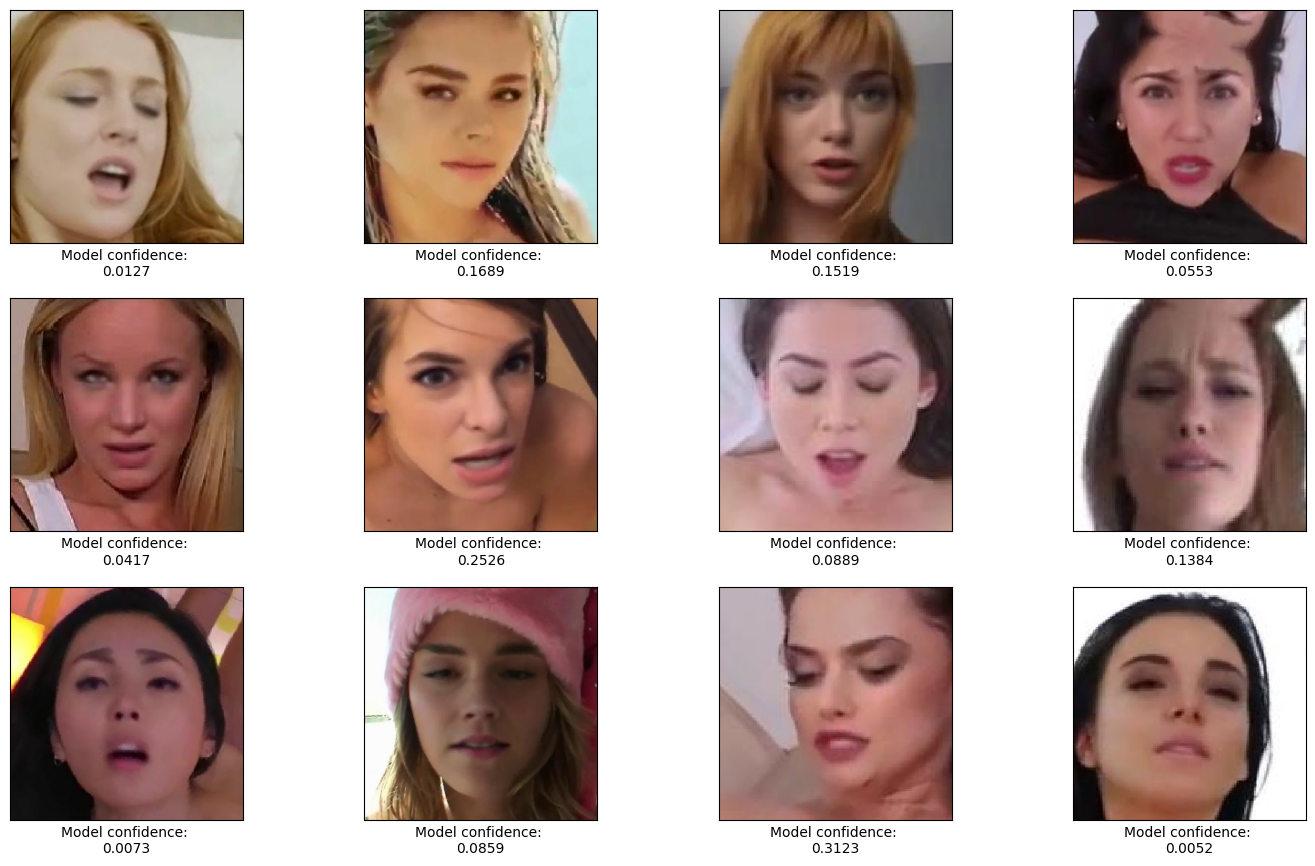

In [81]:
plotter(correct_deepfake, correct_deepfake_pred)

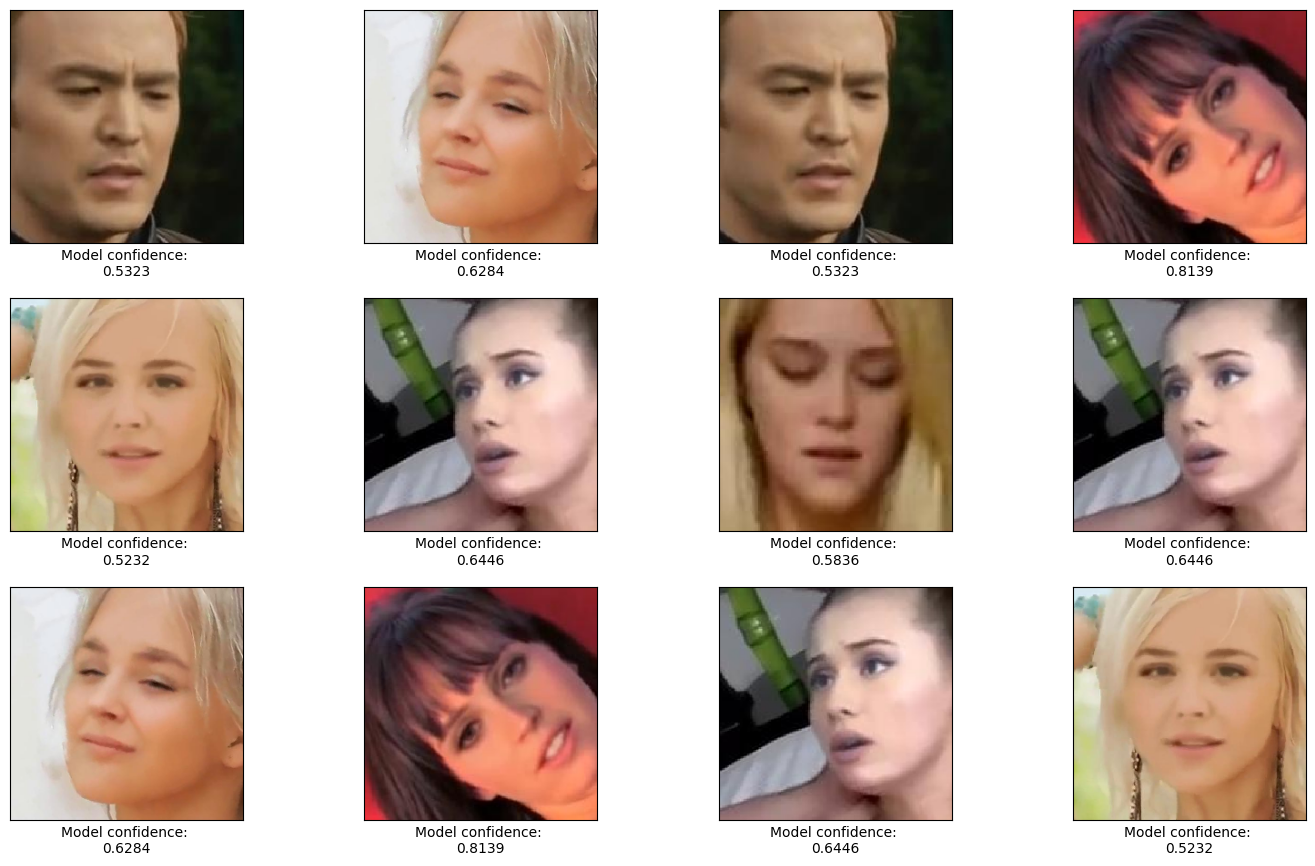

In [82]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)